In [ ]:
import pandas_datareader as pdr
import pandas as pd

In [ ]:
df = pdr.get_data_tiingo('AAPL', api_key='4c260f4e2eb83b092ac0c2d2f109c284d4706dae')
df.to_csv('AAPL.csv')

In [ ]:
df = pd.read_csv('/content/AAPL.csv')

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-10-12 00:00:00+00:00,111.60,112.75,111.44,112.73,30467204,25.779066,26.044711,25.742107,26.040091,121868816,0.0,1.0
1,AAPL,2015-10-13 00:00:00+00:00,111.79,112.45,110.68,110.82,33049256,25.822955,25.975412,25.566550,25.598890,132197024,0.0,1.0
2,AAPL,2015-10-14 00:00:00+00:00,110.21,111.52,109.56,111.29,44462449,25.457983,25.760586,25.307836,25.707458,177849796,0.0,1.0
3,AAPL,2015-10-15 00:00:00+00:00,111.86,112.10,110.49,110.93,37673452,25.839125,25.894564,25.522661,25.624299,150693808,0.0,1.0
4,AAPL,2015-10-16 00:00:00+00:00,111.04,112.00,110.53,111.78,39232609,25.649709,25.871464,25.531901,25.820645,156930436,0.0,1.0


In [ ]:
df.shape

(1258, 14)

In [ ]:
df1 = df.reset_index()['close']

In [ ]:
df1

0       111.60
1       111.79
2       110.21
3       111.86
4       111.04
         ...  
1253    113.02
1254    116.50
1255    113.16
1256    115.08
1257    114.97
Name: close, Length: 1258, dtype: float64

In [ ]:
df1.shape

(1258,)

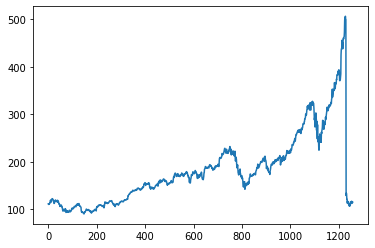

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
## LSTM is very sensitive to the scale of data,so we can apply min-max scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(1258, 1)

In [ ]:
#splltting dataset
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_set, test_set = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [ ]:
training_size, test_set.shape

(817, (441, 1))

In [ ]:
# convert a array into dataset metrix
import numpy as np

def create_dataset(dataset, time_step = 1):
  datax, datay = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    datax.append(a)
    datay.append(dataset[i+time_step, 0])
  return np.array(datax), np.array(datay)


In [ ]:
time_stamp = 100
x_train, y_train = create_dataset(train_set, time_stamp)
x_test, y_test = create_dataset(test_set, time_stamp)


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((716, 100), (716,), (340, 100), (340,))

In [ ]:
#reshape input to be [sample,time stamp, features] which is required for lstm
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
## creating LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 1s 96ms/step - loss: 0.0089 - val_loss: 0.0587
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0221
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 5.6632e-04 - val_loss: 0.0244
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 4.1832e-04 - val_loss: 0.0210
Epoch 5/100
12/12 [==============================] - 0s 17ms/step - loss: 3.7372e-04 - val_loss: 0.0203
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 3.4871e-04 - val_loss: 0.0199
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 3.3946e-04 - val_loss: 0.0195
Epoch 8/100
12/12 [==============================] - 0s 17ms/step - loss: 3.3781e-04 - val_loss: 0.0191
Epoch 9/100
12/12 [==============================] - 0s 16ms/step - loss: 3.3120e-04 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 0s 17ms/step - los

In [ ]:
#let do the predictions and check the performance metrics
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [ ]:
## transform to original form 
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_pred))

154.51574714636786

In [ ]:
##test data RMSE
math.sqrt(mean_squared_error(y_test, test_pred))

263.07908062156696

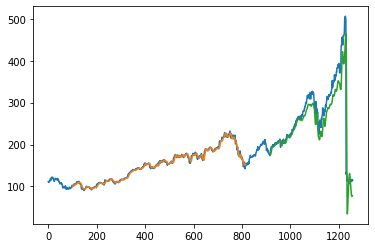

In [ ]:
### plotting

import numpy as np
look_back = 100
trainp_plot = np.empty_like(df1)
trainp_plot[:,:] = np.nan
trainp_plot[look_back:len(train_pred)+look_back,:] = train_pred

testp_plot = np.empty_like(df1)
testp_plot[:,:]=np.nan 
testp_plot[len(train_pred)+(look_back*2)+1:len(df1)-1,:] = test_pred

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainp_plot)
plt.plot(testp_plot)
plt.show()